In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [3]:
#importing total X_train(features)
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X.csv')

In [4]:
#importing total Y_train(target)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y.csv')

In [5]:
#splitting train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
#model building and fitting
lgbm_clf = lgb.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier()

In [7]:
#train accuracy
lgbm_clf.score(X_train, y_train)

0.8938444444444444

In [8]:
del X_train, y_train

In [9]:
#test accuracy
yPred = lgbm_clf.predict(X_test)
lgbm_clf.score(X_test, y_test)

0.8918333333333334

In [10]:
#various performance scores
acc = accuracy_score(y_test, yPred)
print("The accuracy is {}".format(acc))
  
prec = precision_score(y_test, yPred)
print("The precision is {}".format(prec))
  
rec = recall_score(y_test, yPred)
print("The recall is {}".format(rec))
  
f1 = f1_score(y_test, yPred)
print("The F1-Score is {}".format(f1))
  
MCC = matthews_corrcoef(y_test, yPred)
print("The Matthews correlation coefficient is{}".format(MCC))

The accuracy is 0.8918333333333334
The precision is 0.5798293723339427
The recall is 0.09517855356606982
The F1-Score is 0.16351606805293004
The Matthews correlation coefficient is0.20329475761030455


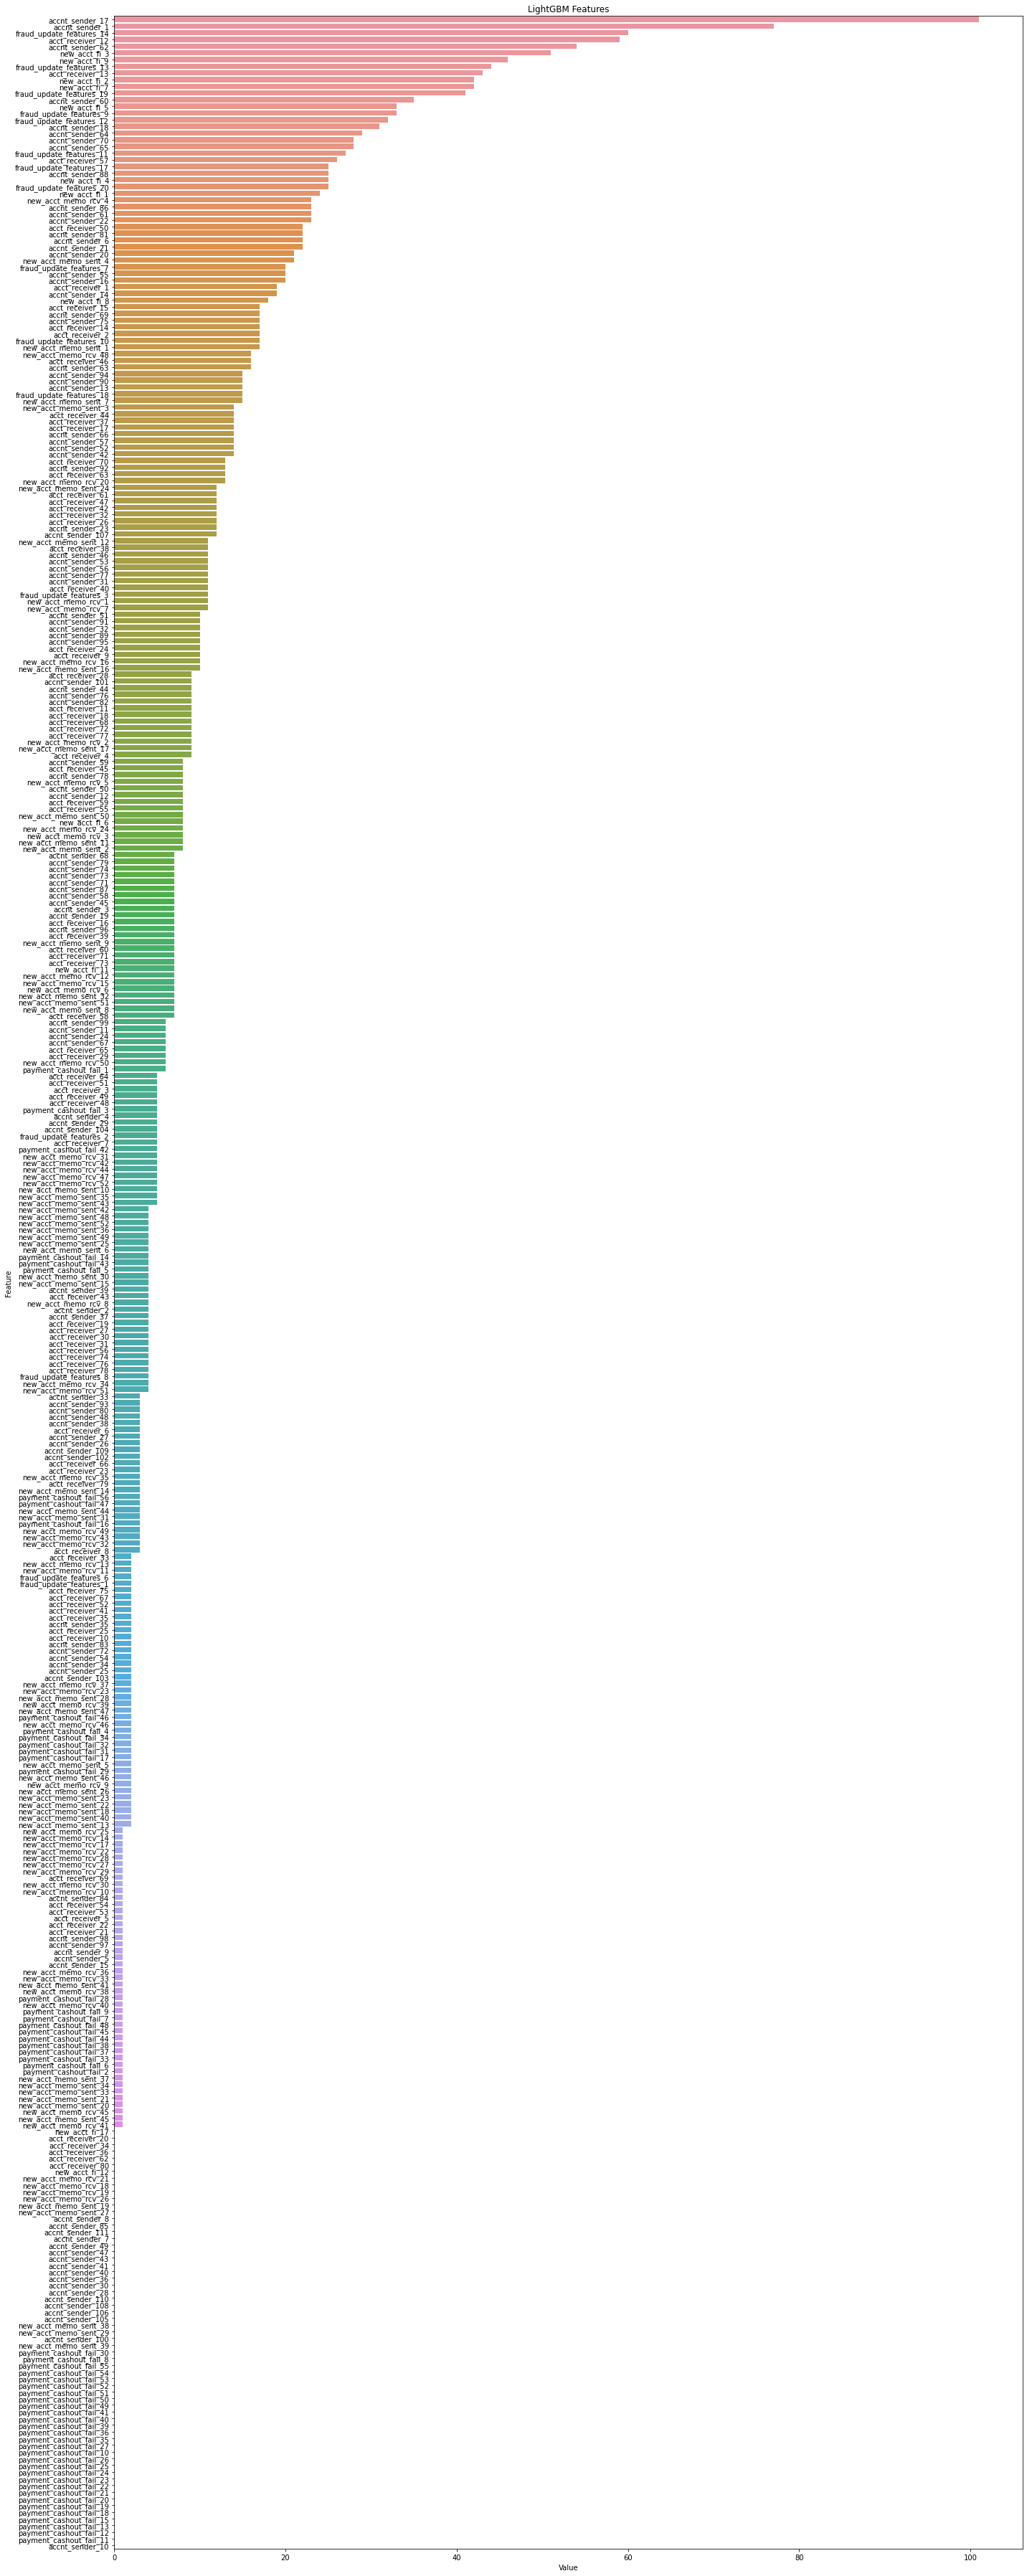

<Figure size 432x288 with 0 Axes>

In [11]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_clf.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp.sort_values(by="Value", ascending=False,inplace=True)
plt.figure(figsize=(20, 50))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [23]:
feature_imp_top= feature_imp.iloc[:100]

In [24]:
feature_imp_top

,Value,Feature
378,101,accnt_sender_17
377,77,accnt_sender_1
376,60,fraud_update_features_14
375,59,acct_receiver_12
374,54,accnt_sender_62
...,...,...
287,10,acct_receiver_9
288,10,new_acct_memo_rcv_16
289,10,new_acct_memo_sent_16
274,9,acct_receiver_28


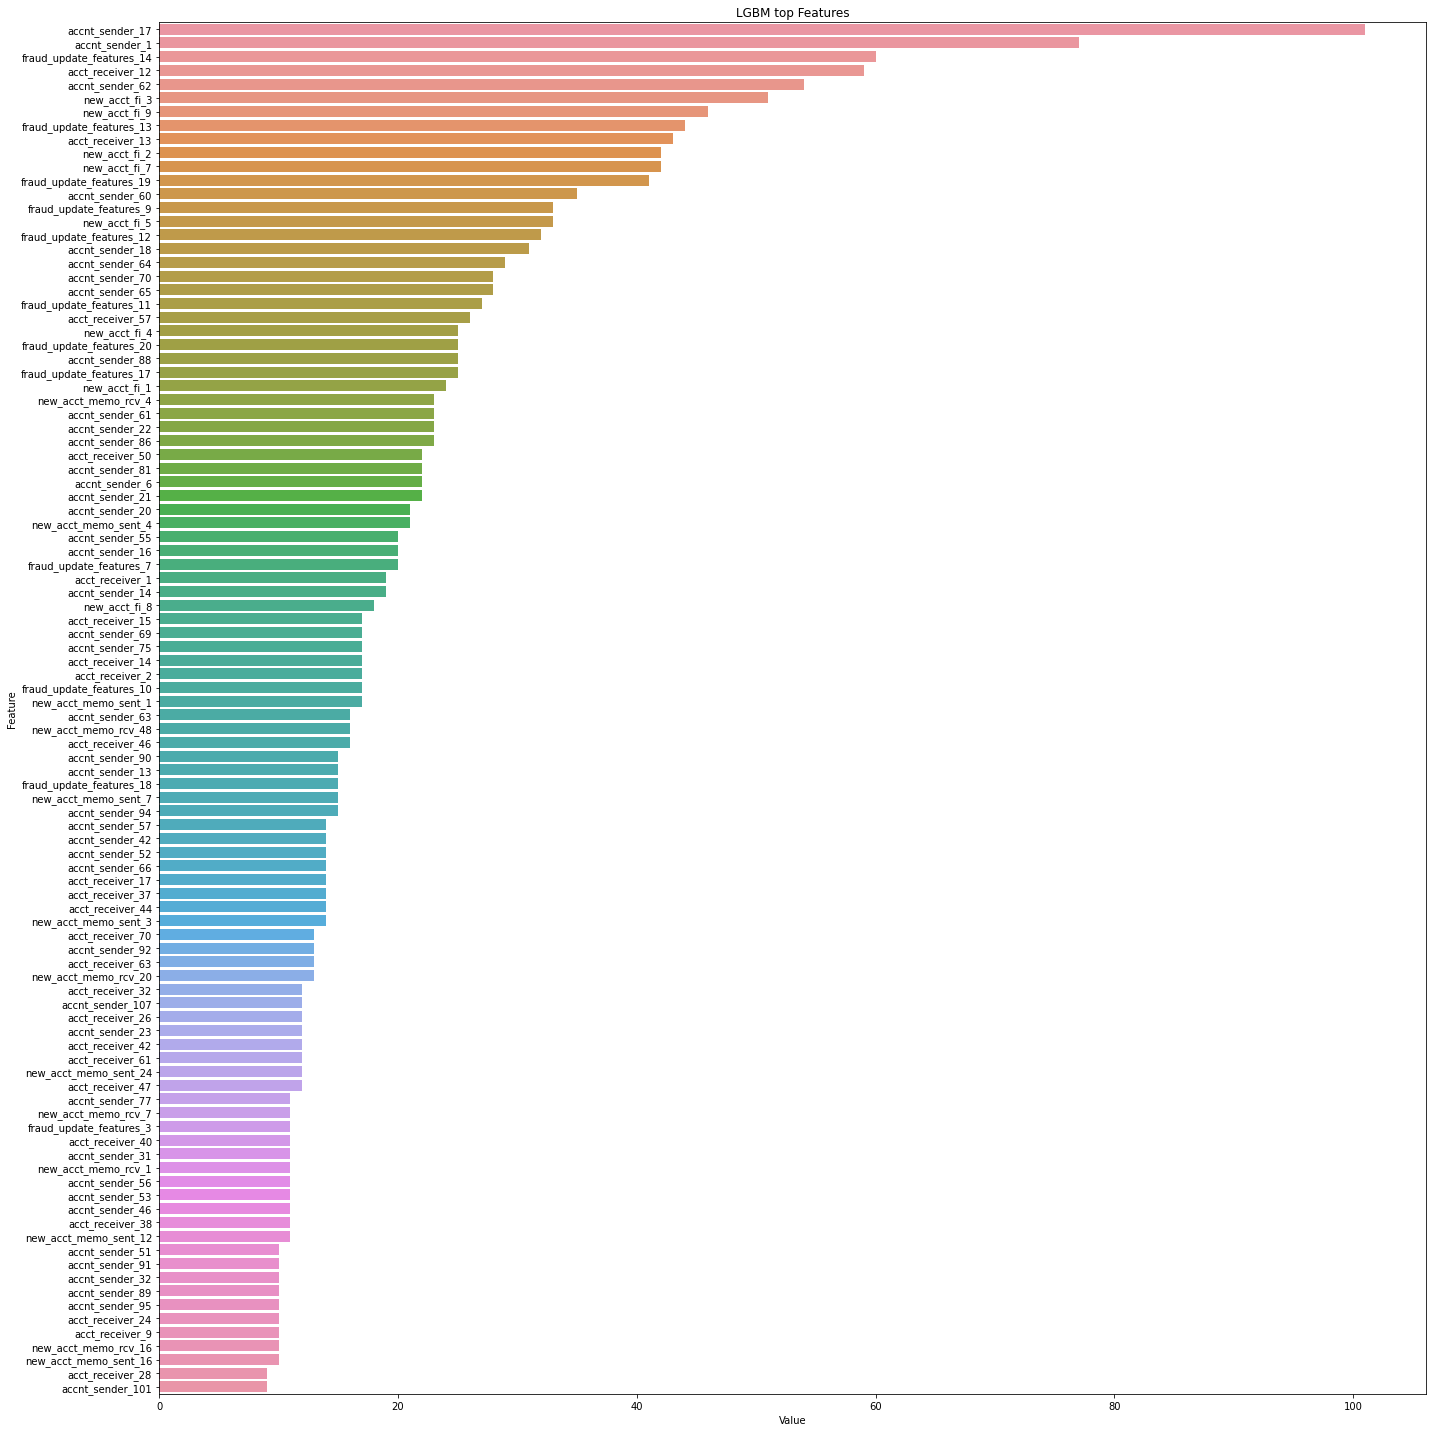

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp_top.sort_values(by="Value", ascending=False))
plt.title('LGBM top Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')
from google.colab import files
files.download('lgbm_importances.png')

In [15]:
features= list(feature_imp_top.Feature)

In [16]:
#ks score function
def ks_(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    return 

In [17]:
#creating data frame to check ks score for validation data
ks=pd.DataFrame(lgbm_clf.predict_proba(X_test))
del ks[0]

In [18]:

y_test.reset_index(inplace=True)
ks['target']=y_test['target']

#ks table
ks_(ks,'target',1)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.235445  0.888536  6868.0    11132.0     34.35%         6.96%   
2       0.148932  0.235444  3417.0    14583.0     17.09%         9.11%   
3       0.109141  0.148929  2330.0    15670.0     11.65%         9.79%   
4       0.086596  0.109139  1844.0    16156.0      9.22%        10.10%   
5       0.071848  0.086596  1482.0    16518.0      7.41%        10.32%   
6       0.061424  0.071848  1180.0    16820.0      5.90%        10.51%   
7       0.052908  0.061424   934.0    17066.0      4.67%        10.67%   
8       0.045182  0.052908   800.0    17200.0      4.00%        10.75%   
9       0.036939  0.045181   660.0    17340.0      3.30%        10.84%   
10      0.010174  0.036939   479.0    17521.0      2.40%        10.95%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             34.35

In [19]:
#creating data frame of cust ids with probabilities
X_t= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_t.csv')
test_cust= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_cust.csv')
result_model = pd.DataFrame(lgbm_clf.predict_proba(X_t))
result=pd.concat([test_cust['cust_id'],result_model[1] ], axis=1)
result.rename(columns={1:'target'},inplace=True)

In [20]:
result

,cust_id,target
0,10146566,0.115618
1,10203613,0.053455
2,10322129,0.020527
3,10373212,0.061564
4,10487539,0.068566
...,...,...
179995,45739460,0.039613
179996,56006782,0.027964
179997,61138340,0.035289
179998,65715392,0.026921


In [21]:
#uploading results(probabilities)
#result.to_csv('/content/drive/MyDrive/Colab Notebooks/results.csv',index=False)